![](https://raw.githubusercontent.com/quantumjot/btrack/main/docs/_static/btrack_logo.png)

# Example of using btrack to track cells in timelapse microscopy data

This notebook covers the following functionality:

* Load segmentation data and localize objects
* Load a table of localized objects 
* Run tracking algorithm
* Inspect the output
* Visualize the results in napari

In addition, we have an extensive tutorial of the cell tracking application as part of *napari*:  

https://napari.org/tutorials/tracking/cell_tracking.html

## Importing btrack and loading example datasets

In [1]:
import btrack

from btrack import datasets

We can automatically download some example data to play with:

In [2]:
CONFIG_FILE = datasets.cell_config()
SEGMENTATION_FILE = datasets.example_segmentation_file()
OBJECTS_FILE = datasets.example_track_objects_file()

## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage

In [4]:
segmentation = imread(SEGMENTATION_FILE)

In [5]:
segmentation.shape

(500, 1200, 1600)

### show the segmentation as a montage

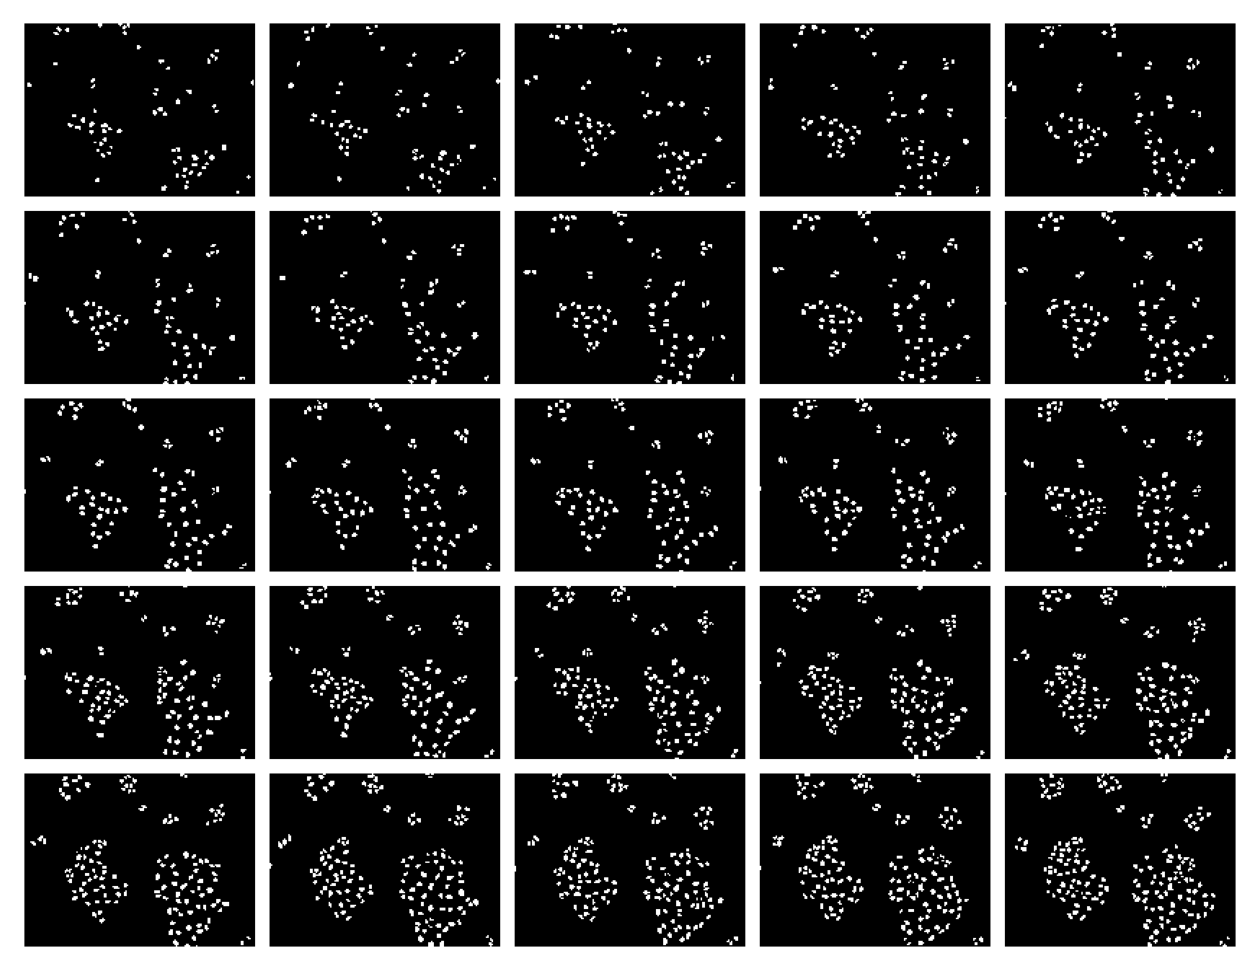

In [6]:
seq = montage(
    segmentation[::20, ::10, ::10], 
    grid_shape=(5, 5), 
    padding_width=10, 
    fill=255,
)

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(seq, cmap=plt.cm.gray)
ax.axis(False)
plt.show()

### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [7]:
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]

objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=tuple(FEATURES), 
    num_workers=4,  # parallelise this
)

[INFO][2023/04/19 09:04:46 AM] Localizing objects from segmentation...
[INFO][2023/04/19 09:04:46 AM] Processing using 4 workers.
100%|██████████| 500/500 [00:18<00:00, 27.41it/s]
[INFO][2023/04/19 09:05:05 AM] Objects are of type: <class 'dict'>
[INFO][2023/04/19 09:05:05 AM] ...Found 52890 objects in 500 frames.


We can also inspect each returned object to determine it's properties:

In [8]:
objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,minor_axis_length,orientation,solidity
0,0,517.573657,9.07279,0.0,0,False,7,5,577,33.260603,22.856213,1.455708,0.968121


## Running the tracking

In [9]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200))

    # track them (in interactive mode)
    tracker.track(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    # tracker.export("tracks.h5", obj_type="obj_type_1")
    

[INFO][2023/04/19 09:05:05 AM] Loaded btrack: /Users/arl/Dropbox/Code/py3/btrack/btrack/libs/libtracker.dylib
[INFO][2023/04/19 09:05:05 AM] Starting BayesianTracker session
[INFO][2023/04/19 09:05:05 AM] Loading configuration file: /Users/arl/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2023/04/19 09:05:05 AM] Objects are of type: <class 'list'>
[INFO][2023/04/19 09:05:06 AM] Starting tracking... 
[INFO][2023/04/19 09:05:06 AM] Update using: ['VISUAL', 'MOTION']
[INFO][2023/04/19 09:05:06 AM] Tracking objects in frames 0 to 99 (of 500)...
[INFO][2023/04/19 09:05:06 AM]  - Timing (Bayesian updates: 0.29ms, Linking: 0.20ms)
[INFO][2023/04/19 09:05:06 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2023/04/19 09:05:06 AM]  - Stats (Active: 78, Lost: 23, Conflicts resolved: 100)
[INFO][2023/04/19 09:05:06 AM] Tracking objects in frames 100 to 199 (of 500)...
[INFO][2023/04/19 09:05:06 AM]  - Timing (Bayesian updates: 0.35ms, Linking: 0.23ms)
[INFO][2023/04/19

GLPK Integer Optimizer 5.0
1348 rows, 1126 columns, 1604 non-zeros
1126 integer variables, all of which are binary
Preprocessing...
674 rows, 1126 columns, 1604 non-zeros
1126 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 674
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
674 rows, 1126 columns, 1604 non-zeros
*     0: obj =   2.154386691e+03 inf =   0.000e+00 (156)
*   133: obj =   1.044601617e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   133: mip =     not found yet >=              -inf        (1; 0)
+   133: >>>>>   1.044601617e+03 >=   1.044601617e+03   0.0% (1; 0)
+   133: mip =   1.044601617e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [10]:
cell = tracks[1]

In [11]:
cell

,ID,t,x,y,z,parent,root,state,generation,dummy,area,minor_axis_length,major_axis_length,orientation,solidity
0,2,0,657.399225,4.426357,0.0,2,2,5,0,False,258,11.908765,28.650424,1.534682,0.973585
1,2,1,657.715481,4.029289,0.0,2,2,5,0,False,239,11.040913,28.759037,1.557410,0.983539
2,2,2,656.904167,4.125000,0.0,2,2,5,0,False,240,11.037060,28.651696,1.530523,0.979592
3,2,3,656.217993,4.667820,0.0,2,2,5,0,False,289,12.138052,31.094621,1.543631,0.989726
4,2,4,653.219298,6.710526,0.0,2,2,5,0,False,342,17.054772,26.502698,-1.478267,0.966102
5,2,5,654.336420,7.256173,0.0,2,2,5,0,False,324,18.407481,23.073315,1.537582,0.975904
6,2,6,653.078014,6.971631,0.0,2,2,5,0,False,282,18.031229,20.781504,1.287062,0.975779
7,2,7,653.767790,6.632959,0.0,2,2,5,0,False,267,17.685798,20.536610,1.248538,0.960432
8,2,8,651.496124,6.116279,0.0,2,2,5,0,False,258,16.412172,21.267710,1.426393,0.962687
9,2,9,650.666667,8.757106,0.0,2,2,5,0,False,387,21.986416,23.116262,-1.434154,0.962687


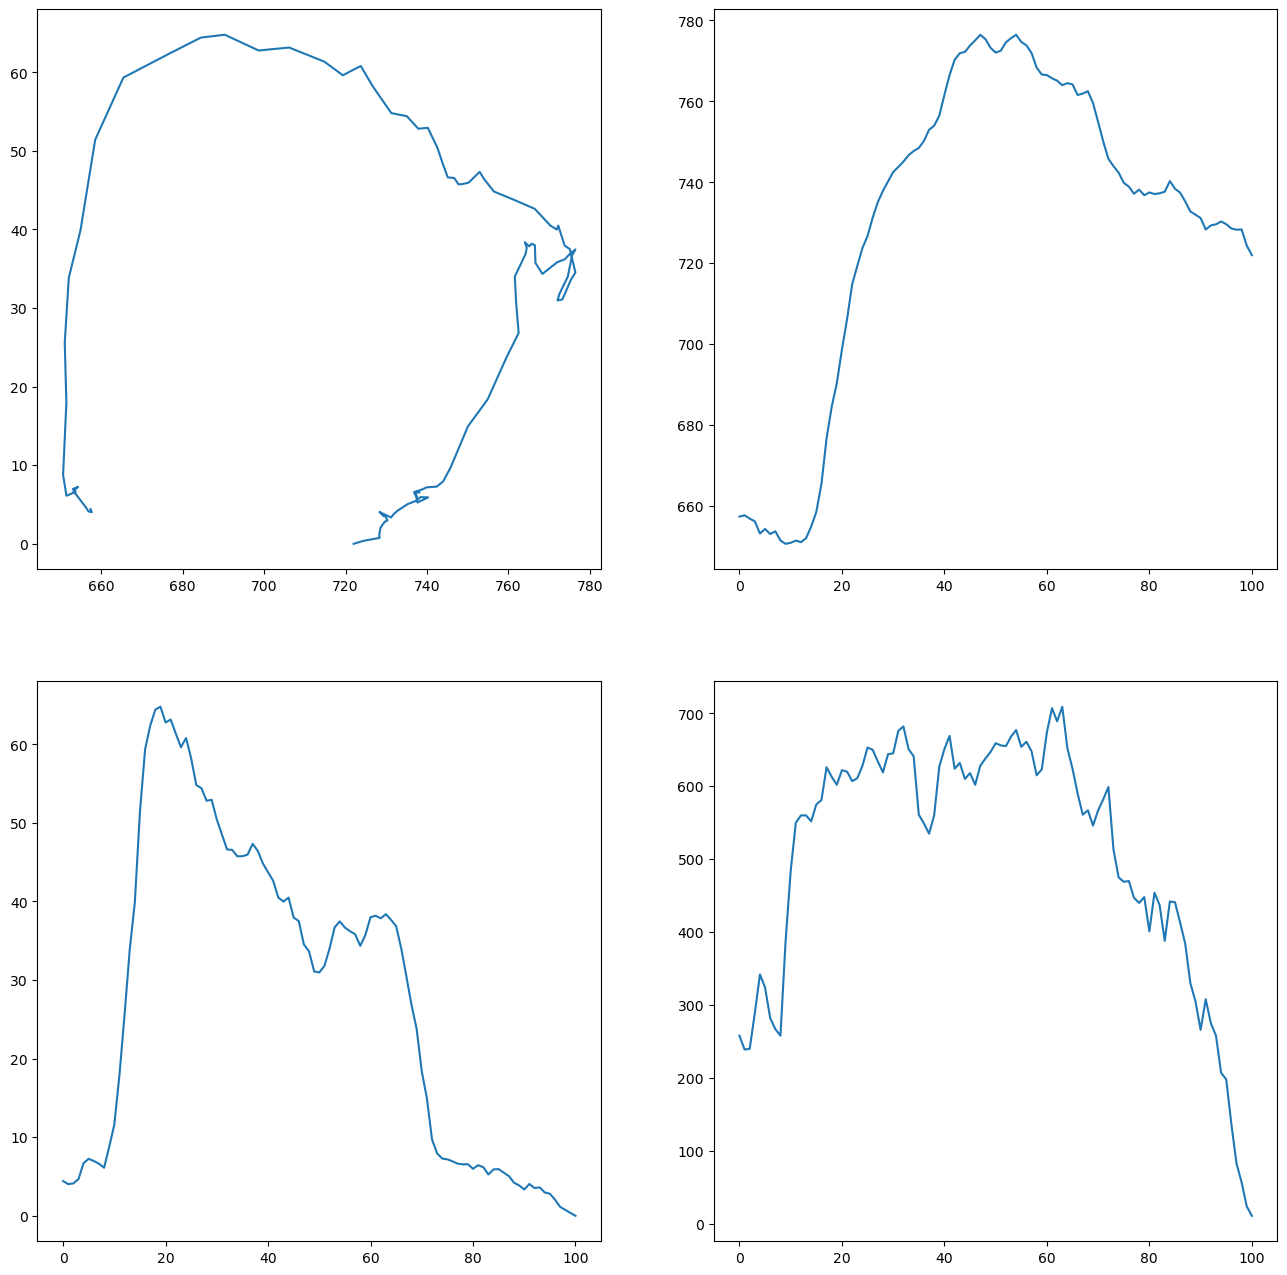

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
ax1.plot(cell.x, cell.y)
ax2.plot(cell.t, cell.x)
ax3.plot(cell.t, cell.y)
ax4.plot(cell.t, cell["area"])
plt.show()

## Visualising the data with napari

Finally, we an inspect the entire tracking output using *napari*:

In [13]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

# the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
)

<Tracks layer 'Tracks' at 0x2c2d29a20>